In [2]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
from sklearn.utils.class_weight import compute_class_weight

In [4]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,BatchNormalization,concatenate,Input,MaxPooling2D,Flatten,Activation
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply,Conv2D,Activation,SeparableConv2D

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

CODE

In [8]:
def conv3x3(inputs, out_channels, stride=1, groups=1, dilation=1):
    return SeparableConv2D(out_channels, kernel_size=3, strides=stride,
                  padding='same', use_bias=False, dilation_rate=dilation)(inputs)

In [9]:
def conv1x1(inputs, out_channels, stride=1):
    return SeparableConv2D(out_channels, kernel_size=1, strides=stride, use_bias=False)(inputs)

BASIC BLOCK

In [10]:
def basic_block(inputs, out_channels, stride):
    x = conv3x3(inputs, out_channels, stride)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)

    x = conv3x3(x, out_channels)
    x = BatchNormalization()(x)

    shortcut = inputs
    if stride != 1 or inputs.shape[-1] != out_channels:
        shortcut = conv1x1(inputs, out_channels, stride)
        shortcut = BatchNormalization()(shortcut)

    x = x + shortcut
    x = tf.nn.relu(x)

    return x

MULTI SCALE BLOCK

In [11]:
def MulScaleBlock_tf(inputs, inplanes, planes, stride=1, downsample=None):
    norm_layer = BatchNormalization
    scale_width = int(planes / 4)

    conv1 = conv3x3(inputs, planes, stride)
    bn1 = norm_layer()(conv1)
    relu = tf.nn.relu(bn1)

    sp_x = tf.split(relu, num_or_size_splits=4, axis=-1)

    conv1_2_1 = conv3x3(sp_x[0], scale_width)
    bn1_2_1 = norm_layer()(conv1_2_1)
    out_1_1 = tf.nn.relu(bn1_2_1)

    conv1_2_2 = conv3x3(sp_x[1]+out_1_1, scale_width)
    bn1_2_2 = norm_layer()(conv1_2_2)
    out_1_2 = tf.nn.relu(bn1_2_2)

    conv1_2_3 = conv3x3(sp_x[2]+out_1_2, scale_width)
    bn1_2_3 = norm_layer()(conv1_2_3)
    out_1_3 = tf.nn.relu(bn1_2_3)

    conv1_2_4 = conv3x3(sp_x[3]+out_1_3, scale_width)
    bn1_2_4 = norm_layer()(conv1_2_4)
    out_1_4 = tf.nn.relu(bn1_2_4)

    out_1 = tf.concat([out_1_1, out_1_2, out_1_3, out_1_4], axis=-1)

    conv2_2_4 = conv3x3(sp_x[3], scale_width)
    bn2_2_4 = norm_layer()(conv2_2_4)
    out_2_4 = tf.nn.relu(bn2_2_4)

    conv2_2_3 = conv3x3(sp_x[2] + out_2_4, scale_width)
    bn2_2_3 = norm_layer()(conv2_2_3)
    out_2_3 = tf.nn.relu(bn2_2_3)

    conv2_2_2 = conv3x3(sp_x[1] + out_2_3, scale_width)
    bn2_2_2 = norm_layer()(conv2_2_2)
    out_2_2 = tf.nn.relu(bn2_2_2)

    conv2_2_1 = conv3x3(sp_x[0] + out_2_2, scale_width)
    bn2_2_1 = norm_layer()(conv2_2_1)
    out_2_1 = tf.nn.relu(bn2_2_1)

    out_2 = tf.concat([out_2_1, out_2_2, out_2_3, out_2_4], axis=-1)

    out = out_1 + out_2

    identity = inputs
    identity_shape = tf.keras.backend.int_shape(identity)
    out_shape = tf.keras.backend.int_shape(out)

    if stride != 1 or identity_shape[-1] != out_shape[-1]:
        identity = conv3x3(identity, out_shape[-1], stride)
        identity = norm_layer()(identity)

    out += identity
    out = tf.nn.relu(out)


    return out

ATTENTION


In [12]:
def channel_attention_module(x, ratio=16):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x,ratio = 8)
    x = spatial_attention_module(x)
    return x

In [13]:
def attention_block(inputs, out_channels, stride=1):
    x = conv3x3(inputs, out_channels, stride)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)

    x = conv3x3(x, out_channels)
    x = BatchNormalization()(x)
    y = x
    x = cbam(x)
    x = Multiply()([x, y])
    shortcut = inputs
    if stride != 1 or inputs.shape[-1] != out_channels:
        shortcut = conv1x1(inputs, out_channels, stride)
        shortcut = BatchNormalization()(shortcut)

    x = x + shortcut
    x = tf.nn.relu(x)
    return x


PATCHES

In [14]:
def divide_feature_map(feature_map):
    # Get the dimensions of the input feature map
    batch_size, height, width, num_channels = feature_map.shape
    # Divide the feature map into 4 patches along the height and width dimensions
    patch1 = feature_map[:, :height//2, :width//2, :]
    patch2 = feature_map[:, :height//2, width//2:, :]
    patch3 = feature_map[:, height//2:, :width//2, :]
    patch4 = feature_map[:, height//2:, width//2:, :]

    # Return the 4 patches
    return patch1, patch2, patch3, patch4

# Example usage:
# Assuming 'input_feature_map' is your input feature map tensor
input_feature_map = tf.random.normal((1, 28, 28, 256))  # Example shape
patch1, patch2, patch3, patch4 = divide_feature_map(input_feature_map)


MODEL

In [15]:
def make_layer(inputs, block, in_channels, out_channels, blocks, stride=1):
    x = block(inputs, out_channels, stride)
    for _ in range(1, blocks):
        x = block(x, out_channels)
    return x

In [16]:
# model=[]

In [17]:
def manet(input_shape=(224, 224, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    #First Conv2D
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    #Basic Block
    x = basic_block(x,64,1)
    x = basic_block(x,128,1)
    x = basic_block(x,128,2)
    x = basic_block(x,128,2)

    #Patches Dividing
    patch_11, patch_12, patch_21, patch_22 = divide_feature_map(x)

    #Branch-1

    #Attention Block

    #Block-1
    attn1_out = attention_block(patch_11,256,2)
    attn1_out = attention_block(attn1_out,256,2)
    attn1_out = attention_block(attn1_out,512,1)
    attn1_out = attention_block(attn1_out,512,1)

    #Block-2
    attn2_out = attention_block(patch_12,256,2)
    attn2_out = attention_block(attn2_out,256,2)
    attn2_out = attention_block(attn2_out,512,1)
    attn2_out = attention_block(attn2_out,512,1)

    #Block-3
    attn3_out = attention_block(patch_21,256,2)
    attn3_out = attention_block(attn3_out,256,2)
    attn3_out = attention_block(attn3_out,512,1)
    attn3_out = attention_block(attn3_out,512,1)

    #Block-4
    attn4_out = attention_block(patch_22,256,2)
    attn4_out = attention_block(attn4_out,256,2)
    attn4_out = attention_block(attn4_out,512,1)
    attn4_out = attention_block(attn4_out,512,1)

    #Concatenation
    branch_1_out = tf.concat([attn1_out, attn2_out, attn3_out, attn4_out], axis=-1)
    #Avgpool,Flatten And Dense
    b1_out = GlobalAveragePooling2D()(branch_1_out)
    b1_out = Flatten()(b1_out)
    b1_out = Dense(num_classes,activation = 'softmax',input_shape=(512,))(b1_out)


    #Branch-2

    b2_out = MulScaleBlock_tf(x,128,256,2)
    b2_out = MulScaleBlock_tf(b2_out,128,256,2)

    b2_out = MulScaleBlock_tf(b2_out,256,512,2)
    b2_out = MulScaleBlock_tf(b2_out,256,512,2)

    b2_out = GlobalAveragePooling2D()(b2_out)
    b2_out = Flatten()(b2_out)
    b2_out = Dense(num_classes,activation = 'softmax',input_shape=(512,))(b2_out)

    final_out=b1_out+b2_out
    # final_out = tf.concat([b1_out,b2_out],axis = -1)
    # final_out = Dense(num_classes,activation = 'softmax',input_shape=(14,))(b2_out)

    model = tf.keras.Model(inputs=inputs, outputs=final_out)

    return model

In [18]:
num_classes = 7
model = manet(input_shape=(224, 224, 3), num_classes=7)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [20]:
verbose = True
patience = 50

In [21]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience/4), verbose=verbose)
model_names = 'model.h5'
model_checkpoint = ModelCheckpoint(filepath=model_names, monitor='val_loss', verbose=verbose, save_best_only=True)
callbacks = [model_checkpoint,  early_stop, reduce_lr]

In [22]:
# Define the loss function, optimizer, and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

TRAINING

In [24]:
# Label mapping

# {
#     1 : 'surprise',
#     2 : 'fear',
#     3 : 'disgust',
#     4 : 'happy',
#     5 : 'sad',
#     6 : 'angry',
#     7 : 'neutral'
# }

In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    shear_range=0.15,
    zoom_range=0.15,
)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/raf-db-dataset/DATASET/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 12271 images belonging to 7 classes.


In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/raf-db-dataset/DATASET/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3068 images belonging to 7 classes.


In [26]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.3589147286821706,
 1: 6.238434163701068,
 2: 2.4449093444909344,
 3: 0.3673512154233026,
 4: 0.884460141271443,
 5: 2.4865248226950354,
 6: 0.6945324881141046}

In [27]:
# Train the model
history = model.fit(
    train_generator,
    epochs=150,
    batch_size=32,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=test_generator,
    class_weight=class_weight_dict
)

Epoch 1/150
384/384 [==============================] - ETA: 0s - loss: 2.0737 - accuracy: 0.1819
Epoch 1: val_loss improved from inf to 1.87387, saving model to model.h5
384/384 [==============================] - 277s 478ms/step - loss: 2.0737 - accuracy: 0.1819 - val_loss: 1.8739 - val_accuracy: 0.0528 - lr: 0.0010
Epoch 2/150
384/384 [==============================] - ETA: 0s - loss: 1.9414 - accuracy: 0.2518
Epoch 2: val_loss did not improve from 1.87387
384/384 [==============================] - 146s 380ms/step - loss: 1.9414 - accuracy: 0.2518 - val_loss: 4.7415 - val_accuracy: 0.1607 - lr: 0.0010
Epoch 3/150
384/384 [==============================] - ETA: 0s - loss: 1.8908 - accuracy: 0.2658
Epoch 3: val_loss improved from 1.87387 to 1.72100, saving model to model.h5
384/384 [==============================] - 146s 381ms/step - loss: 1.8908 - accuracy: 0.2658 - val_loss: 1.7210 - val_accuracy: 0.3263 - lr: 0.0010
Epoch 4/150
384/384 [==============================] - ETA: 0s - los

In [28]:
model.save('model.h5')

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

96/96 [==============================] - 6s 58ms/step - loss: 0.6191 - accuracy: 0.7885
Test accuracy: 0.7884615659713745


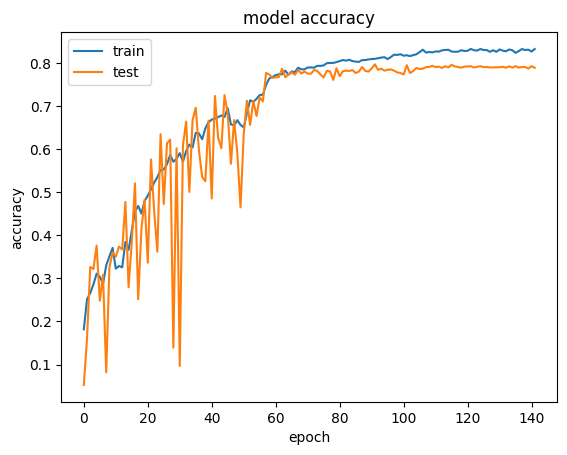

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

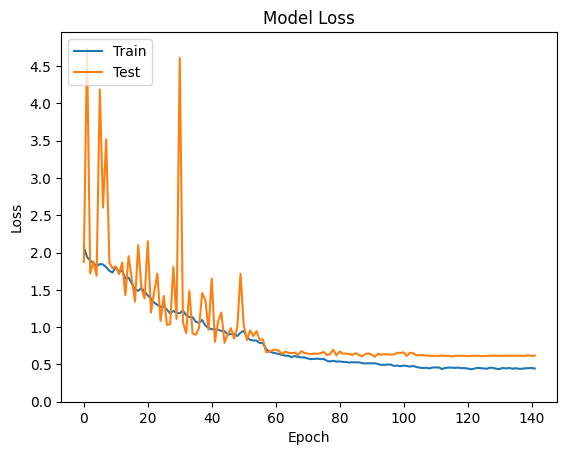

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks(np.arange(0, 5, 0.5)) 

plt.show()